In [1]:
import pandas as pd
import pickle as pkl
import numpy as np 
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# Import data

In [2]:
fire_data = pd.DataFrame(pd.read_pickle('data/gridmet.pkl')).dropna()
fire_data.columns = pd.read_pickle('data/gridmetCols.pkl')

# convert data type
fire_data = fire_data.apply(pd.to_numeric, errors='ignore')
fire_data.day = pd.to_datetime(fire_data.day)

# # remove outliers: might not make sense to do
# fire_num = fire_data.select_dtypes(include=np.number)
# fire_num = fire_num[(np.abs(stats.zscore(fire_num)) < 3).all(axis=1)]
# fire_not = fire_data.select_dtypes(exclude=np.number)
# fire_data = (fire_num.merge(fire_not, left_index=True, right_index=True)
#             .reset_index(drop=True))

fire_data.info()
display(fire_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122342 entries, 0 to 122341
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   day                122342 non-null  datetime64[ns]
 1   season             122342 non-null  object        
 2   burning_index_g    122342 non-null  float64       
 3   relative_humidity  122342 non-null  float64       
 4   air_temperature    122342 non-null  float64       
 5   wind_speed         122342 non-null  float64       
 6   fire               122342 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 6.5+ MB


,day,season,burning_index_g,relative_humidity,air_temperature,wind_speed,fire
0,2017-01-01,winter,0.0,55.100002,273.799988,4.6,0
1,2017-01-01,winter,0.0,43.700001,277.000000,4.8,0
2,2017-01-01,winter,0.0,47.799999,276.000000,5.1,0
3,2017-01-01,winter,0.0,63.900002,272.100006,5.6,0
4,2017-01-01,winter,0.0,53.299999,273.299988,6.0,0


## Get Sample (n=40000)

In [3]:
fire_samp = fire_data.sample(n=40000, random_state=88)
fire_samp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 96420 to 25954
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   day                40000 non-null  datetime64[ns]
 1   season             40000 non-null  object        
 2   burning_index_g    40000 non-null  float64       
 3   relative_humidity  40000 non-null  float64       
 4   air_temperature    40000 non-null  float64       
 5   wind_speed         40000 non-null  float64       
 6   fire               40000 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 2.4+ MB


## Convert Season Column to Dummy Variable

In [4]:
fire_samp = (fire_samp.drop(['season'], axis=1)
             .merge(pd.get_dummies(fire_samp.season), 
                    left_index=True, right_index=True))
fire_samp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 96420 to 25954
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   day                40000 non-null  datetime64[ns]
 1   burning_index_g    40000 non-null  float64       
 2   relative_humidity  40000 non-null  float64       
 3   air_temperature    40000 non-null  float64       
 4   wind_speed         40000 non-null  float64       
 5   fire               40000 non-null  int64         
 6   autumn             40000 non-null  uint8         
 7   spring             40000 non-null  uint8         
 8   summer             40000 non-null  uint8         
 9   winter             40000 non-null  uint8         
dtypes: datetime64[ns](1), float64(4), int64(1), uint8(4)
memory usage: 3.3 MB


## Split into train and test

In [5]:
y = fire_samp['fire']
X = fire_samp.drop(columns=['fire', 'day'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28000, 8), (12000, 8), (28000,), (12000,))

In [6]:
X_train.select_dtypes(exclude='uint8').columns

Index(['burning_index_g', 'relative_humidity', 'air_temperature',
       'wind_speed'],
      dtype='object')

# Models

In [7]:
# remove numerical columns with VIF > 5; not dummy variables
def VIF(df, columns):
    values = sm.add_constant(df[columns]).values
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    return pd.Series(vif[1:], index=columns)

VIF(X_train, X_train.select_dtypes(exclude='uint8').columns)

burning_index_g      2.899758
relative_humidity    3.309895
air_temperature      2.444346
wind_speed           1.340995
dtype: float64

In [8]:
def scores(y_test, y_pred):
    cm  = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    TPR = cm[1][1] / sum(cm[1])            # TP/(TP+FP)
    FPR = cm[0][1] / sum(cm[0])            # FP/(FP+TN)
    PRE = cm[1][1] / (cm[0][1] + cm[1][1]) # TP/(TP+FP)
    print(f'Accuracy: {acc:.4f}, TPR: {TPR:.4f}, FPR: {FPR:.4f}, Precision: {PRE:.4f}')
    return acc, TPR, FPR, PRE

## Baseline

In [9]:
cm = confusion_matrix(y_test,[0]*y_test.shape[0])
baseline_acc = y_test.value_counts().values.max() / len(y_test)
baseline_TPR = cm[1][1] / sum(cm[1])
baseline_FPR = cm[0][1] / sum(cm[0])
baseline_PRE = 0 
print(f'Accuracy: {baseline_acc:.4f}, TPR: {baseline_TPR:.4f}, FPR: {baseline_FPR:.4f}, Precision: {baseline_PRE:.4f}')

Accuracy: 0.5923, TPR: 0.0000, FPR: 0.0000, Precision: 0.0000


## Logistic Regression

In [10]:
log = LogisticRegression(random_state=88)
log.fit(X_train, y_train)
y_pred = log.predict(X_test)
log_acc,log_TPR,log_FPR,log_PRE = scores(y_test, y_pred)

Accuracy: 0.8012, TPR: 0.7966, FPR: 0.1957, Precision: 0.7370


## CART: Decision Tree Classification

In [11]:
# without cross validation 
dtc = DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=20, 
                             random_state=88)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
dtc_acc,dtc_TPR,dtc_FPR,dtc_PRE = scores(y_test, y_pred)

Accuracy: 0.7946, TPR: 0.7456, FPR: 0.1717, Precision: 0.7494


In [12]:
# with cross validation 
grid_values = {'ccp_alpha': np.linspace(0, 0.10, 201),
               'min_samples_leaf': [5],
               'min_samples_split': [20],
               'random_state': [88]}

dtc_c = DecisionTreeClassifier(random_state=88)
dtc_cv = GridSearchCV(dtc_c, param_grid=grid_values, scoring='accuracy', cv=10) 
dtc_cv.fit(X_train, y_train)
y_pred = dtc_cv.best_estimator_.predict(X_test)

cart_best_ccp_alpha = dtc_cv.best_params_['ccp_alpha']
print(f'Best ccp_alpha: {cart_best_ccp_alpha:.4f}')
dtc_cv_acc,dtc_cv_TPR,dtc_cv_FPR,dtc_cv_PRE = scores(y_test, y_pred)

Best ccp_alpha: 0.0005
Accuracy: 0.8303, TPR: 0.8314, FPR: 0.1705, Precision: 0.7705


## Vanilla Bagging

In [13]:
vb = RandomForestClassifier(max_features=X_train.shape[1], random_state=88)
vb.fit(X_train, y_train)
y_pred = vb.predict(X_test)

vb_acc,vb_TPR,vb_FPR,vb_PRE = scores(y_test, y_pred)

Accuracy: 0.8232, TPR: 0.7964, FPR: 0.1584, Precision: 0.7758


## Random Forest

In [14]:
# without cross validation
rf = RandomForestClassifier(min_samples_leaf=5, min_samples_split=20, 
                            random_state=88)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

rf_acc,rf_TPR,rf_FPR,rf_PRE = scores(y_test, y_pred)

Accuracy: 0.8347, TPR: 0.8275, FPR: 0.1603, Precision: 0.7805


In [15]:
# with cross validation 
grid_values = {'max_features': np.arange(1, X_train.shape[1]),
               'min_samples_leaf': [5],
               'n_estimators': [500],
               'random_state': [88]}

rf_c = RandomForestClassifier(random_state=88)
rf_cv = GridSearchCV(rf_c, param_grid=grid_values, scoring='accuracy', cv=10)
rf_cv.fit(X_train, y_train)

y_pred = rf_cv.predict(X_test)

rf_max_features = rf_cv.best_params_['max_features']
print(f'Best max_features: {rf_max_features}')
rf_cv_acc,rf_cv_TPR,rf_cv_FPR,rf_cv_PRE = scores(y_test, y_pred)

Accuracy: 0.8346, TPR: 0.8283, FPR: 0.1611, Precision: 0.7797


## Linear Discriminant Analysis

In [16]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
lda_acc,lda_TPR,lda_FPR,lda_PRE = scores(y_test, y_pred)

Accuracy: 0.8108, TPR: 0.8680, FPR: 0.2285, Precision: 0.7234


## Gradient Boosting Classifier

In [17]:
gbc = GradientBoostingClassifier(n_estimators=500, max_leaf_nodes=10, 
                                 random_state=88) 
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
gbc_acc,gbc_TPR,gbc_FPR,gbc_PRE = scores(y_test, y_pred)

Accuracy: 0.8322, TPR: 0.8293, FPR: 0.1659, Precision: 0.7749


# Comparison table

In [18]:
comp = {'Baseline':[baseline_acc,baseline_TPR,baseline_FPR, baseline_PRE],
        'Logistic Regression':[log_acc,log_TPR,log_FPR, log_PRE],
        'Decision Tree Classifier':[dtc_acc,dtc_TPR,dtc_FPR,dtc_PRE],
        'Decision Tree Classifier with CV':[dtc_cv_acc,dtc_cv_TPR,dtc_cv_FPR,dtc_cv_PRE],
        'Vanilla Bagging':[vb_acc,vb_TPR,vb_FPR,vb_PRE],
        'Random Forest':[rf_acc,rf_TPR, rf_FPR,rf_PRE],
        'Random Forest with CV':[rf_cv_acc,rf_cv_TPR,rf_cv_FPR,rf_cv_PRE],
        'Linear Discriminant Analysis':[lda_acc,lda_TPR, lda_FPR,lda_PRE],
        'Gradient Boosting Classifier':[gbc_acc,gbc_TPR,gbc_FPR,gbc_PRE],
        }

df = pd.DataFrame(data=comp, index=['Accuracy', 'TPR', 'FPR','PRE']).transpose()
df

,Accuracy,TPR,FPR,PRE
Baseline,0.592250,0.000000,0.000000,0.000000
Logistic Regression,0.801167,0.796648,0.195723,0.737001
Decision Tree Classifier,0.794583,0.745555,0.171662,0.749384
Decision Tree Classifier with CV,0.830250,0.831392,0.170536,0.770455
Vanilla Bagging,0.823167,0.796444,0.158435,0.775831
Random Forest,0.834750,0.827509,0.160265,0.780455
Random Forest with CV,0.834583,0.828326,0.161109,0.779723
Linear Discriminant Analysis,0.810833,0.867975,0.228507,0.723386
Gradient Boosting Classifier,0.832167,0.829348,0.165893,0.774871


# Bootstrap

In [21]:
def perform_bootstrap(X_test, y_test, models: dict, sample=500, random_state=88):
    results = dict()
    for m in range(len(models)):
        results[list(models.keys())[m]] = []
    for bs_iter in range(sample):
        bs_index = np.random.choice(X_test.index, len(X_test.index), replace=True)
        bs_data = X_test.loc[bs_index]
        bs_test = y_test.loc[bs_index]
        for m in range(len(models)):
            model = list(models.values())[m]
            try:
                bs_pred = model.predict(bs_data)
            except:
                bs_pred = model.best_estimator_.predict(bs_data)
            cm = confusion_matrix(bs_test, bs_pred)
            acc = accuracy_score(bs_test, bs_pred)
            TPR = cm[1][1] / sum(cm[1])
            FPR = cm[0][1] / sum(cm[0])
            results[list(models.keys())[m]].append([acc, TPR, FPR])
    return results

In [22]:
models = {'Logistic Regression':log,
          'Decision Tree Classifier':dtc,
          'Decision Tree Classifier with CV':dtc_cv,
          'Vanilla Bagging':vb,
          'Random Forest':rf,
          'Random Forest with CV':rf_cv,
          'Linear Discriminant Analysis':lda,
          'Gradient Boosting Classifier':gbc,
          }
# [acc, TPR, FPR]
bs = perform_bootstrap(X_test, y_test, models, sample=1000)

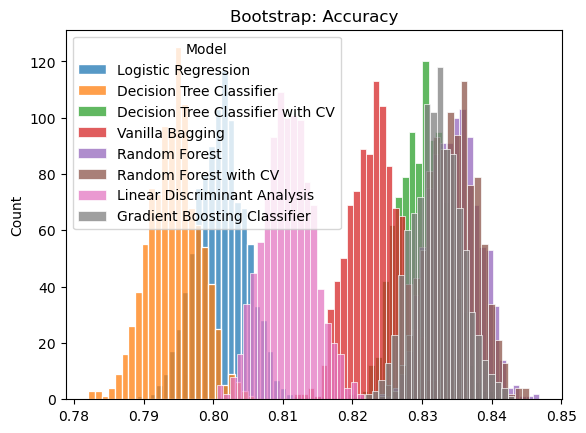

In [23]:
# Bootstrap: Accuracy
for i in range(len(bs)):
    sns.histplot(np.array(list(bs.values())[i])[:,0], 
                 edgecolor='white', color=sns.color_palette()[i]);
plt.legend(title='Model', labels=list(bs.keys()));
plt.title('Bootstrap: Accuracy');

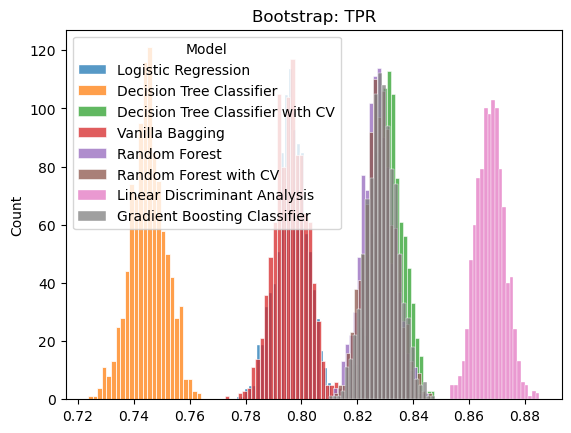

In [24]:
# Bootstrap: TPR
for i in range(len(bs)):
    sns.histplot(np.array(list(bs.values())[i])[:,1], 
                 edgecolor='white', color=sns.color_palette()[i]);
plt.legend(title='Model', labels=list(bs.keys()));
plt.title('Bootstrap: TPR');

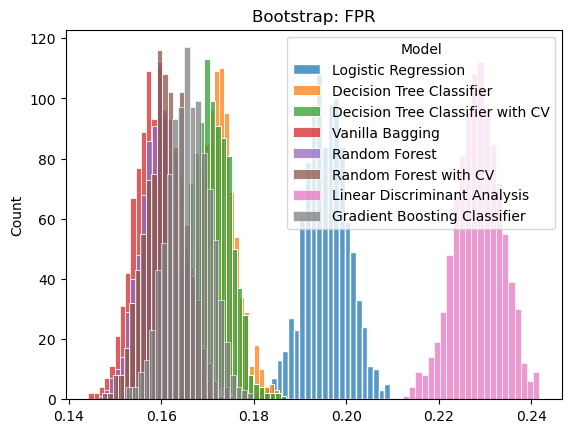

In [25]:
# Bootstrap: FPR
for i in range(len(bs)):
    sns.histplot(np.array(list(bs.values())[i])[:,2], 
                 edgecolor='white', color=sns.color_palette()[i]);
plt.legend(title='Model', labels=list(bs.keys()));
plt.title('Bootstrap: FPR');

# Confidence Interval

In [29]:
rf_bs_acc = np.array(list(bs.values())[2])[:,0]
CI = np.quantile(rf_bs_acc, np.array([0.025,0.975]))
print(f"RF Accuracy: 95% {np.round(CI, 4)}; mean ({np.mean(rf_bs_acc):.4f}); SD ({np.std(rf_bs_acc):.4f})")
rf_bs_TPR = np.array(list(bs.values())[2])[:,1]
CI = np.quantile(rf_bs_TPR, np.array([0.025,0.975]))
print(f"RF TPR:      95% {np.round(CI, 4)}; mean ({np.mean(rf_bs_TPR):.4f}); SD ({np.std(rf_bs_TPR):.4f})")
rf_bs_FPR = np.array(list(bs.values())[2])[:,2]
CI = np.quantile(rf_bs_FPR, np.array([0.025,0.975]))
print(f"RF FPR:      95% {np.round(CI, 4)}; mean ({np.mean(rf_bs_FPR):.4f}); SD ({np.std(rf_bs_FPR):.4f})")

RF Accuracy: 95% [0.8237 0.8367]; mean (0.8302); SD (0.0035)
RF TPR:      95% [0.8199 0.8418]; mean (0.8311); SD (0.0055)
RF FPR:      95% [0.1614 0.1785]; mean (0.1705); SD (0.0045)


In [44]:
metric = ['Accuracy', 'TPR     ', 'FPR     ']
m = list(bs.keys())
for i in range(len(bs)):
    met = np.array(list(bs.values())[i])
    print(m[i])
    for j in range(3):# [acc, TPR, FPR]
        CI = np.quantile(met[:,j], np.array([0.025,0.975]))
        print(f"{metric[j]}: 95% {np.round(CI, 4)}; mean ({np.mean(met[:,j]):.4f}); SD ({np.std(met[:,j]):.4f})")
    print('\n')

Logistic Regression
Accuracy: 95% [0.7942 0.808 ]; mean (0.8011); SD (0.0036)
TPR     : 95% [0.7845 0.8079]; mean (0.7964); SD (0.0059)
FPR     : 95% [0.1861 0.2047]; mean (0.1957); SD (0.0047)


Decision Tree Classifier
Accuracy: 95% [0.7872 0.8011]; mean (0.7944); SD (0.0036)
TPR     : 95% [0.7319 0.7572]; mean (0.7450); SD (0.0064)
FPR     : 95% [0.1627 0.1809]; mean (0.1717); SD (0.0044)


Decision Tree Classifier with CV
Accuracy: 95% [0.8237 0.8367]; mean (0.8302); SD (0.0035)
TPR     : 95% [0.8199 0.8418]; mean (0.8311); SD (0.0055)
FPR     : 95% [0.1614 0.1785]; mean (0.1705); SD (0.0045)


Vanilla Bagging
Accuracy: 95% [0.8166 0.8298]; mean (0.8231); SD (0.0036)
TPR     : 95% [0.7837 0.8074]; mean (0.7961); SD (0.0060)
FPR     : 95% [0.1493 0.1669]; mean (0.1583); SD (0.0043)


Random Forest
Accuracy: 95% [0.8285 0.8413]; mean (0.8347); SD (0.0035)
TPR     : 95% [0.8159 0.8386]; mean (0.8271); SD (0.0056)
FPR     : 95% [0.1513 0.1687]; mean (0.1602); SD (0.0044)


Random Fores